In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings
import spacy
from tqdm.notebook import tqdm_notebook

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import make_pipeline
from nltk.tokenize import RegexpTokenizer

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is alr

In [2]:
# load the dataset
data=pd.read_csv('financial_sentiment_data.csv',encoding='Latin-1')
data

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


## Data Exploration

### Number of Words

In [3]:
data['word_count'] = data['Sentence'].apply(lambda x: len(str(x).split(" ")))
data[['Sentence','word_count']].head(10)

,Sentence,word_count
0,The GeoSolutions technology will leverage Bene...,32
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",11
2,"For the last quarter of 2010 , Componenta 's n...",39
3,According to the Finnish-Russian Chamber of Co...,20
4,The Swedish buyout firm has sold its remaining...,23
5,$SPY wouldn't be surprised to see a green close,9
6,Shell's $70 Billion BG Deal Meets Shareholder ...,8
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,34
8,Kone 's net sales rose by some 14 % year-on-ye...,18
9,The Stockmann department store will have a tot...,33


### Number of characters

In [4]:
data['char_count'] = data['Sentence'].str.len() ## this also includes spaces
data[['Sentence','char_count']].head()

,Sentence,char_count
0,The GeoSolutions technology will leverage Bene...,218
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",55
2,"For the last quarter of 2010 , Componenta 's n...",193
3,According to the Finnish-Russian Chamber of Co...,128
4,The Swedish buyout firm has sold its remaining...,135


### Average Word Length

In [5]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

data['avg_word'] = data['Sentence'].apply(lambda x: avg_word(x))
data[['Sentence','avg_word']].head()

,Sentence,avg_word
0,The GeoSolutions technology will leverage Bene...,5.843750
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",4.090909
2,"For the last quarter of 2010 , Componenta 's n...",3.974359
3,According to the Finnish-Russian Chamber of Co...,5.450000
4,The Swedish buyout firm has sold its remaining...,4.913043


### Number of stopwords

In [6]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['stopwords'] = data['Sentence'].apply(lambda x: len([x for x in x.split() if x in stop]))
data[['Sentence','stopwords']].head()

,Sentence,stopwords
0,The GeoSolutions technology will leverage Bene...,6
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",4
2,"For the last quarter of 2010 , Componenta 's n...",15
3,According to the Finnish-Russian Chamber of Co...,8
4,The Swedish buyout firm has sold its remaining...,5


### Number of special characters

In [7]:
data['hashtags'] = data['Sentence'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
data[['Sentence','hashtags']].head()

,Sentence,hashtags
0,The GeoSolutions technology will leverage Bene...,0
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
2,"For the last quarter of 2010 , Componenta 's n...",0
3,According to the Finnish-Russian Chamber of Co...,0
4,The Swedish buyout firm has sold its remaining...,0


### Number of numerics

In [8]:
data['numerics'] = data['Sentence'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
data[['Sentence','numerics']].head()

,Sentence,numerics
0,The GeoSolutions technology will leverage Bene...,0
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
2,"For the last quarter of 2010 , Componenta 's n...",1
3,According to the Finnish-Russian Chamber of Co...,0
4,The Swedish buyout firm has sold its remaining...,0


In [9]:
data.drop(['numerics','hashtags','stopwords','avg_word','char_count','word_count'],axis=1,inplace=True)

### Number of Uppercase words

In [10]:
data['upper'] = data['Sentence'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
data[['Sentence','upper']].head()

,Sentence,upper
0,The GeoSolutions technology will leverage Bene...,1
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",2
2,"For the last quarter of 2010 , Componenta 's n...",0
3,According to the Finnish-Russian Chamber of Co...,0
4,The Swedish buyout firm has sold its remaining...,0


### Number of Rare Words

In [11]:
freq = pd.Series(' '.join(data['Sentence']).split()).value_counts()[-10:]
freq

65,200                     1
Signs                      1
Up,                        1
Desano                     1
barleycorn                 1
@78.47                     1
:D                         1
Aramco,                    1
Motiva,                    1
https://t.co/mK7MEMtADT    1
dtype: int64

### Percentage of Links attached

In [12]:
data.Sentence.str.contains('https://').value_counts() / len(data)

False    0.979973
True     0.020027
Name: Sentence, dtype: float64

### Total number of Sentences in the available DataFrame

In [13]:
# Total tweets
print('Total Sentences:', len(data.index), '\n')

Total Sentences: 5842 



### Spelling correction

In [14]:
from textblob import TextBlob
data['Sentence'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    The GeoSolutions technology will beverage Bene...
1    $ESI on lows, down $1.50 to $2.50 of a real po...
2    For the last quarter of 2010 , Component 's ne...
3    According to the Finnish-Russian Chamber of Co...
4    The Swedish dugout firm has sold its remaining...
Name: Sentence, dtype: object

## N-grams

In [15]:
TextBlob(data['Sentence'][3]).ngrams(1)

[WordList(['According']),
 WordList(['to']),
 WordList(['the']),
 WordList(['Finnish-Russian']),
 WordList(['Chamber']),
 WordList(['of']),
 WordList(['Commerce']),
 WordList(['all']),
 WordList(['the']),
 WordList(['major']),
 WordList(['construction']),
 WordList(['companies']),
 WordList(['of']),
 WordList(['Finland']),
 WordList(['are']),
 WordList(['operating']),
 WordList(['in']),
 WordList(['Russia'])]

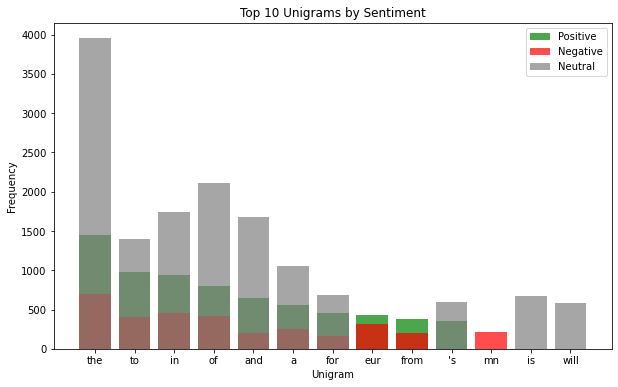

In [16]:
from textblob import TextBlob
import matplotlib.pyplot as plt

# Define a function to generate unigrams
def generate_unigrams(text):
    blob = TextBlob(text)
    return blob.words.lower()

# Calculate the frequency of unigrams for each sentiment category
unigrams = {
    'positive': pd.Series([word for sentence in data[data['Sentiment'] == 'positive']['Sentence'] for word in generate_unigrams(sentence)]).value_counts(),
    'negative': pd.Series([word for sentence in data[data['Sentiment'] == 'negative']['Sentence'] for word in generate_unigrams(sentence)]).value_counts(),
    'neutral': pd.Series([word for sentence in data[data['Sentiment'] == 'neutral']['Sentence'] for word in generate_unigrams(sentence)]).value_counts()
}

# Plot the results as a bar chart
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(unigrams['positive'].index[:10], unigrams['positive'].values[:10], color='green', alpha=0.7, label='Positive')
ax.bar(unigrams['negative'].index[:10], unigrams['negative'].values[:10], color='red', alpha=0.7, label='Negative')
ax.bar(unigrams['neutral'].index[:10], unigrams['neutral'].values[:10], color='gray', alpha=0.7, label='Neutral')

ax.set_xlabel('Unigram')
ax.set_ylabel('Frequency')
ax.set_title('Top 10 Unigrams by Sentiment')
ax.legend()

plt.show()

In [17]:
TextBlob(data['Sentence'][2]).ngrams(2)

[WordList(['For', 'the']),
 WordList(['the', 'last']),
 WordList(['last', 'quarter']),
 WordList(['quarter', 'of']),
 WordList(['of', '2010']),
 WordList(['2010', 'Componenta']),
 WordList(['Componenta', "'s"]),
 WordList(["'s", 'net']),
 WordList(['net', 'sales']),
 WordList(['sales', 'doubled']),
 WordList(['doubled', 'to']),
 WordList(['to', 'EUR131m']),
 WordList(['EUR131m', 'from']),
 WordList(['from', 'EUR76m']),
 WordList(['EUR76m', 'for']),
 WordList(['for', 'the']),
 WordList(['the', 'same']),
 WordList(['same', 'period']),
 WordList(['period', 'a']),
 WordList(['a', 'year']),
 WordList(['year', 'earlier']),
 WordList(['earlier', 'while']),
 WordList(['while', 'it']),
 WordList(['it', 'moved']),
 WordList(['moved', 'to']),
 WordList(['to', 'a']),
 WordList(['a', 'zero']),
 WordList(['zero', 'pre-tax']),
 WordList(['pre-tax', 'profit']),
 WordList(['profit', 'from']),
 WordList(['from', 'a']),
 WordList(['a', 'pre-tax']),
 WordList(['pre-tax', 'loss']),
 WordList(['loss', 'of']

In [18]:
def Gram_Analysis(Corpus, Gram, N):
    
  # Vectorizer
  Vectorizer = CountVectorizer(stop_words = stopwords.words('english'), ngram_range=(Gram,Gram))

  # N-Grams Matrix
  ngrams = Vectorizer.fit_transform(Corpus)

  # N-Grams Frequency
  Count = ngrams.sum(axis=0)

  # List of Words
  words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]

  # Sort Descending With Key = Count
  words = sorted(words, key = lambda x:x[1], reverse = True)
    
  return words[:N]

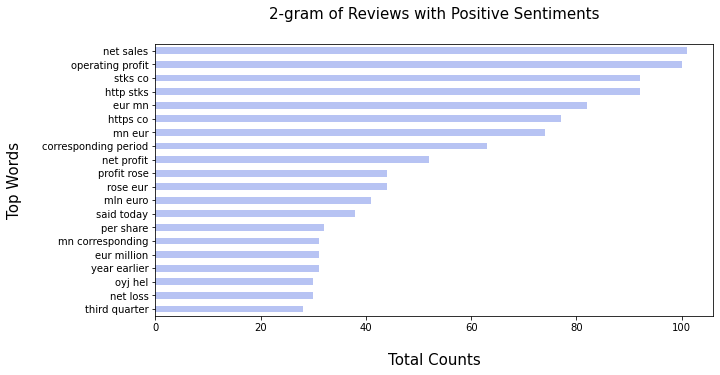

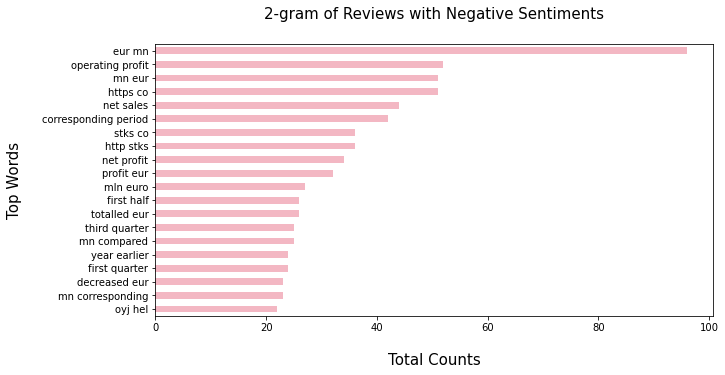

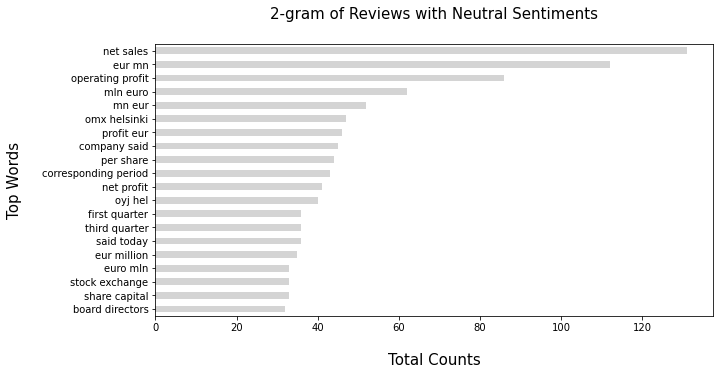

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

# Finding 2-gram for positive reviews
df_positive = data[data["Sentiment"] == "positive"].dropna()
words_p = Gram_Analysis(df_positive["Sentence"], 2, 20)
Bigram_p = pd.DataFrame(words_p, columns = ["Words", "Counts"])

# Visualization for positive reviews
color_p=['#B7C3F3']
Bigram_p.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = color_p, figsize = (10, 5))
plt.title("2-gram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, pad = 25)
plt.xlabel("Total Counts", fontsize = 15, labelpad = 20)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", fontsize = 15, labelpad = 20)
plt.show()

# Finding 2-gram for negative reviews
df_negative = data[data["Sentiment"] == "negative"].dropna()
words_n = Gram_Analysis(df_negative["Sentence"], 2, 20)
Bigram_n = pd.DataFrame(words_n, columns = ["Words", "Counts"])

# Visualization for negative reviews
color_n=['#F3B7C3']
Bigram_n.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = color_n, figsize = (10, 5))
plt.title("2-gram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, pad = 25)
plt.xlabel("Total Counts", fontsize = 15, labelpad = 20)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", fontsize = 15, labelpad = 20)
plt.show()

# Finding 2-gram for neutral reviews
df_neutral = data[data["Sentiment"] == "neutral"].dropna()
words_nu = Gram_Analysis(df_neutral["Sentence"], 2, 20)
Bigram_nu = pd.DataFrame(words_nu, columns = ["Words", "Counts"])

# Visualization for neutral reviews
color_nu=['#D4D4D4']
Bigram_nu.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = color_nu, figsize = (10, 5))
plt.title("2-gram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, pad = 25)
plt.xlabel("Total Counts", fontsize = 15, labelpad = 20)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", fontsize = 15, labelpad = 20)
plt.show()

In [20]:
TextBlob(data['Sentence'][4]).ngrams(3)

[WordList(['The', 'Swedish', 'buyout']),
 WordList(['Swedish', 'buyout', 'firm']),
 WordList(['buyout', 'firm', 'has']),
 WordList(['firm', 'has', 'sold']),
 WordList(['has', 'sold', 'its']),
 WordList(['sold', 'its', 'remaining']),
 WordList(['its', 'remaining', '22.4']),
 WordList(['remaining', '22.4', 'percent']),
 WordList(['22.4', 'percent', 'stake']),
 WordList(['percent', 'stake', 'almost']),
 WordList(['stake', 'almost', 'eighteen']),
 WordList(['almost', 'eighteen', 'months']),
 WordList(['eighteen', 'months', 'after']),
 WordList(['months', 'after', 'taking']),
 WordList(['after', 'taking', 'the']),
 WordList(['taking', 'the', 'company']),
 WordList(['the', 'company', 'public']),
 WordList(['company', 'public', 'in']),
 WordList(['public', 'in', 'Finland'])]

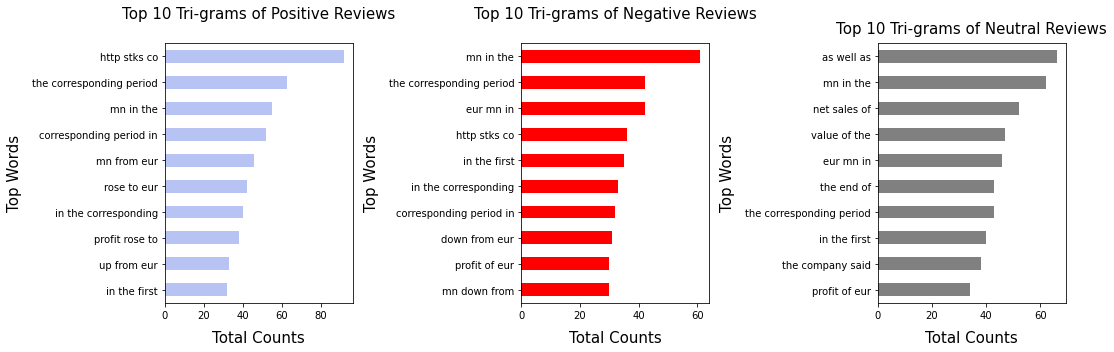

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# Tri-grams
def Gram_Analysis(data, n_gram, top_n):
    vec = CountVectorizer(ngram_range=(n_gram, n_gram)).fit(data)
    words = vec.transform(data)
    sum_words = words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n]

# Positive reviews tri-grams
df_positive = data[data["Sentiment"] == "positive"].dropna()
words_p = Gram_Analysis(df_positive["Sentence"], 3, 10)
TriGram_p = pd.DataFrame(words_p, columns = ["Words", "Counts"])

# Negative reviews tri-grams
df_negative = data[data["Sentiment"] == "negative"].dropna()
words_n = Gram_Analysis(df_negative["Sentence"], 3, 10)
TriGram_n = pd.DataFrame(words_n, columns = ["Words", "Counts"])

# Neutral reviews tri-grams
df_neutral = data[data["Sentiment"] == "neutral"].dropna()
words_neu = Gram_Analysis(df_neutral["Sentence"], 3, 10)
TriGram_neu = pd.DataFrame(words_neu, columns = ["Words", "Counts"])

# Visualization
plt.figure(figsize=(15, 5))
plt.subplot(131)
TriGram_p.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color='#B7C3F3')
plt.title("Top 10 Tri-grams of Positive Reviews", loc = "center", fontsize = 15, pad = 25)
plt.xlabel("Total Counts", fontsize = 15, labelpad = 10)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", fontsize = 15, labelpad = 10)

plt.subplot(132)
TriGram_n.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color='red')
plt.title("Top 10 Tri-grams of Negative Reviews", loc = "center", fontsize = 15, pad = 25)
plt.xlabel("Total Counts", fontsize = 15, labelpad = 10)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", fontsize = 15, labelpad = 10)

plt.subplot(133)
TriGram_neu.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color='grey')
plt.title("Top 10 Tri-grams of Neutral Reviews", loc = "center", fontsize = 15, pad = 10)
plt.xlabel("Total Counts", fontsize = 15, labelpad = 10)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", fontsize = 15, labelpad = 10)

plt.tight_layout()
plt.show()

In [22]:
from textblob import TextBlob

# Load the data into a pandas dataframe
data = pd.read_csv('financial_sentiment_data.csv')

# Create empty lists to store the bigrams and trigrams for each sentiment
pos_bigrams = []
pos_trigrams = []
neg_bigrams = []
neg_trigrams = []
neu_bigrams = []
neu_trigrams = []

# Loop through each sentence in the data and get the bigrams and trigrams
for i in range(len(data)):
    sentence = data['Sentence'][i]
    sentiment = data['Sentiment'][i]
    if sentiment == 'positive':
        pos_bigrams.extend(TextBlob(sentence).ngrams(2))
        pos_trigrams.extend(TextBlob(sentence).ngrams(3))
    elif sentiment == 'negative':
        neg_bigrams.extend(TextBlob(sentence).ngrams(2))
        neg_trigrams.extend(TextBlob(sentence).ngrams(3))
    elif sentiment == 'neutral':
        neu_bigrams.extend(TextBlob(sentence).ngrams(2))
        neu_trigrams.extend(TextBlob(sentence).ngrams(3))

# Convert the lists to sets to remove duplicates
pos_unique_bigrams = set([tuple(item) for item in pos_bigrams])
pos_unique_trigrams = set([tuple(item) for item in pos_trigrams])
neg_unique_bigrams = set([tuple(item) for item in neg_bigrams])
neg_unique_trigrams = set([tuple(item) for item in neg_trigrams])
neu_unique_bigrams = set([tuple(item) for item in neu_bigrams])
neu_unique_trigrams = set([tuple(item) for item in neu_trigrams])

# Print the unique bigrams and trigrams for each sentiment
print('Unique bigrams in positive sentiment:', len(pos_unique_bigrams))
print('Unique trigrams in positive sentiment:', len(pos_unique_trigrams))
print('Unique bigrams in negative sentiment:', len(neg_unique_bigrams))
print('Unique trigrams in negative sentiment:', len(neg_unique_trigrams))
print('Unique bigrams in neutral sentiment:', len(neu_unique_bigrams))
print('Unique trigrams in neutral sentiment:', len(neu_unique_trigrams))

Unique bigrams in positive sentiment: 21404
Unique trigrams in positive sentiment: 25891
Unique bigrams in negative sentiment: 9785
Unique trigrams in negative sentiment: 11326
Unique bigrams in neutral sentiment: 35561
Unique trigrams in neutral sentiment: 46468


In [23]:
# Create a list of all unique bigrams and trigrams
all_unique_bigrams = list(pos_unique_bigrams.union(neg_unique_bigrams).union(neu_unique_bigrams))
all_unique_trigrams = list(pos_unique_trigrams.union(neg_unique_trigrams).union(neu_unique_trigrams))

# Calculate the count of each unique bigram and trigram in the top 100 sentences
top_sentences = data['Sentence'][:100]
grouped_results = pd.DataFrame(columns=['Bigram', 'Trigram', 'Count'])

for bigram in all_unique_bigrams:
    count = 0
    for sentence in top_sentences:
        if ' '.join(bigram) in sentence:
            count += 1
    if count > 0:
        grouped_results = grouped_results.append({'Bigram': ' '.join(bigram), 'Count': count}, ignore_index=True)

for trigram in all_unique_trigrams:
    count = 0
    for sentence in top_sentences:
        if ' '.join(trigram) in sentence:
            count += 1
    if count > 0:
        grouped_results = grouped_results.append({'Trigram': ' '.join(trigram), 'Count': count}, ignore_index=True)

# Sort the results by count in descending order
grouped_results = grouped_results.sort_values(by='Count', ascending=False)

# Export the results to an Excel file
grouped_results.to_excel('unique_bigrams_and_trigrams.xlsx')

C:\Users\Madhu\AppData\Local\Temp\ipykernel_16180\905745513.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped_results = grouped_results.append({'Bigram': ' '.join(bigram), 'Count': count}, ignore_index=True)
C:\Users\Madhu\AppData\Local\Temp\ipykernel_16180\905745513.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped_results = grouped_results.append({'Bigram': ' '.join(bigram), 'Count': count}, ignore_index=True)
C:\Users\Madhu\AppData\Local\Temp\ipykernel_16180\905745513.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped_results = grouped_results.append({'Bigram': ' '.join(bigram), 'Count': count}, ignore_index=True)
C:\Users\Madhu\AppData\Local\Temp\ipykernel_16180\905745513.py:15: FutureWar

In [24]:
# Create a dictionary to store the unique bigrams and trigrams for each sentiment
results = {'Positive': [pos_unique_bigrams, pos_unique_trigrams],
           'Negative': [neg_unique_bigrams, neg_unique_trigrams],
           'Neutral': [neu_unique_bigrams, neu_unique_trigrams]}

# Loop through the dictionary and export the results to separate Excel files
for key in results:
    unique_bigrams = list(results[key][0])[:100]
    unique_trigrams = list(results[key][1])[:100]
    df = pd.DataFrame({'Unique Bigrams': unique_bigrams, 'Unique Trigrams': unique_trigrams})
    filename = key.lower() + '_unique_bigrams_and_trigrams.xlsx'
    df.to_excel(filename, index=False)

# EDA

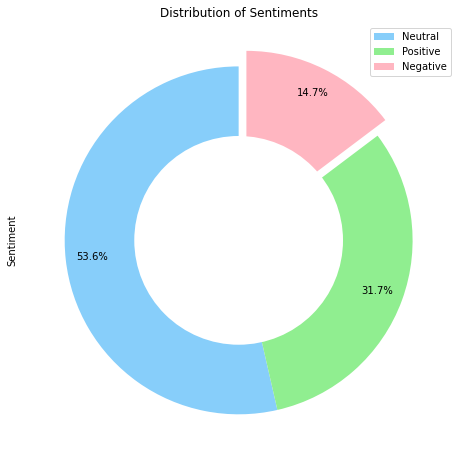

In [25]:
# Define the colors for the pie chart
colors = [ '#87CEFA', '#90EE90','#FFB6C1']  # use your choice of colors here

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 8))
data['Sentiment'].value_counts(normalize=True).plot(kind='pie', colors=colors, ax=ax, autopct='%1.1f%%',
                                                  startangle=90, pctdistance=0.85, explode=[0, 0, 0.1], labels=None)

# Add a circle in the center of the pie chart
circle = plt.Circle(xy=(0, 0), radius=0.6, facecolor='white')
ax.add_artist(circle)

# Add labels and a title
ax.set_title('Distribution of Sentiments')
ax.legend(labels=['Neutral', 'Positive', 'Negative'], loc='upper right')

# Save and show the chart
fig.savefig('sentiment_pie_chart.png', dpi=300)
plt.show()

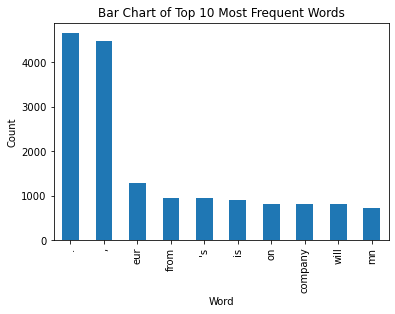

In [26]:
# Generate a bar chart of the top 10 most frequent words
words = pd.Series(' '.join(data['Sentence']).lower().split())
top_words = words[~words.isin(['a', 'an', 'the', 'and', 'or', 'to', 'of', 'in', 'for', 'with'])].value_counts()[:10]
top_words.plot(kind='bar')
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Bar Chart of Top 10 Most Frequent Words')
plt.show()

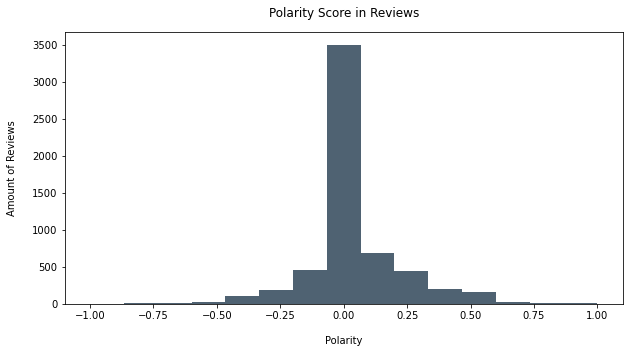

In [27]:
#Polarity scores
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

data["Polarity"] = data["Sentence"].map(lambda Text: TextBlob(Text).sentiment.polarity)
data["Polarity"].plot(kind = "hist", bins = 15, linewidth = 1, color = "#4F6272", figsize = (10,5))

plt.title("Polarity Score in Reviews", pad = 15)
plt.xlabel("Polarity", labelpad = 15)

plt.ylabel("Amount of Reviews", labelpad = 15)
plt.show()

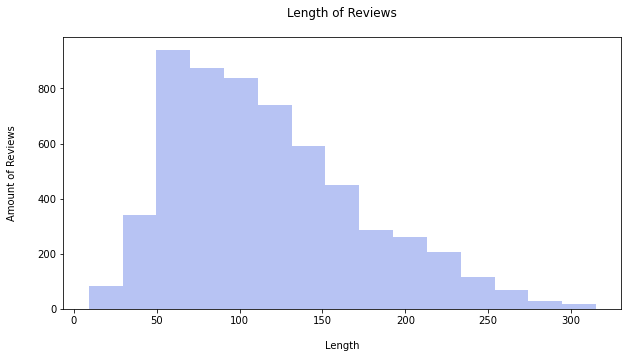

In [28]:
#Length of reviews
data["Length"] = data["Sentence"].astype(str).apply(len)
data["Length"].plot(kind = "hist", bins = 15, linewidth = 1, color = "#B7C3F3", figsize = (10,5))
plt.title("Length of Reviews", pad = 20)
plt.xlabel("Length", labelpad = 15)
plt.ylabel("Amount of Reviews",labelpad = 20)
plt.show()

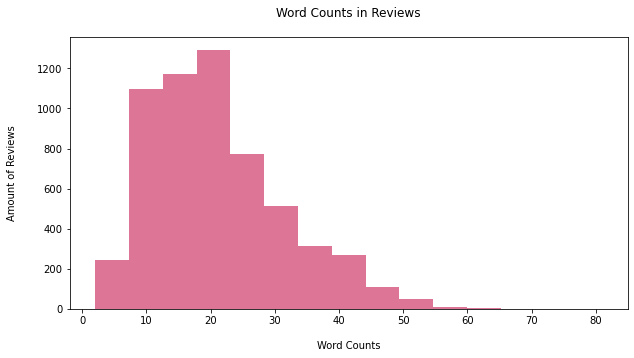

In [29]:
#Word counts
data["Word Counts"] = data["Sentence"].apply(lambda x: len(str(x).split()))
data["Word Counts"].plot(kind = "hist", bins = 15, linewidth = 1, color = "#DD7596", figsize = (10,5))
plt.title("Word Counts in Reviews", pad = 20)
plt.xlabel("Word Counts", labelpad = 15)
plt.ylabel("Amount of Reviews", labelpad = 20)
plt.show()

### BasicText Preprocessing

In [30]:
data=pd.read_csv('financial_sentiment_data.csv',encoding='Latin-1')
data.rename({'Text':'Sentences'},axis=1,inplace=True)
data

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


In [31]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
data['Sentence'] = data['Sentence'].apply(lambda x: " ".join(x.lower() for x in str(x).split() \
                                    if x not in stop_words))
data

,Sentence,Sentiment
0,the geosolutions technology leverage benefon '...,positive
1,"$esi lows, $1.50 $2.50 bk real possibility",negative
2,"for last quarter 2010 , componenta 's net sale...",positive
3,"according finnish-russian chamber commerce , m...",neutral
4,the swedish buyout firm sold remaining 22.4 pe...,neutral
...,...,...
5837,rising costs forced packaging producer huhtama...,negative
5838,nordic walking first used summer training meth...,neutral
5839,"according shipping company viking line , eu de...",neutral
5840,"in building home improvement trade , sales dec...",neutral


In [32]:
lemmatizer = WordNetLemmatizer()
# Removing punctuation, making str to lower, applying Lemmatizer, Removing Stop words
corpus=[]
for i in tqdm_notebook(range(0, len(data))):
    cleaned= re.sub('[^a-zA-Z]', " ", data["Sentence"][i])
    cleaned= cleaned.lower()
    cleaned = cleaned.split()
    cleaned= [lemmatizer.lemmatize(word) for word in cleaned if word not in stopwords.words("english")]
    cleaned= ' '.join(cleaned)
    corpus.append(cleaned)

  0%|          | 0/5842 [00:00<?, ?it/s]

In [33]:
#Saving cleaned data to compare with original data, to ceck amount of information lost
dataframe = pd.DataFrame({"Clean_Sentence": corpus})
dataframe.head()

,Clean_Sentence
0,geosolutions technology leverage benefon gps s...
1,esi low bk real possibility
2,last quarter componenta net sale doubled eur e...
3,according finnish russian chamber commerce maj...
4,swedish buyout firm sold remaining percent sta...


In [34]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 
# We are keeping cleaned tweets in a new column called 'tidy'
dataframe['Clean_Sentence'] = np.vectorize(remove_pattern)(dataframe['Clean_Sentence'], "@[\w]*")
dataframe.head(10)

,Clean_Sentence
0,geosolutions technology leverage benefon gps s...
1,esi low bk real possibility
2,last quarter componenta net sale doubled eur e...
3,according finnish russian chamber commerce maj...
4,swedish buyout firm sold remaining percent sta...
5,spy surprised see green close
6,shell billion bg deal meet shareholder skepticism
7,ssh communication security corp stock exchange...
8,kone net sale rose year year first nine month
9,stockmann department store total floor space s...


In [35]:
Clean_Sentence = []

for index, row in dataframe.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.Clean_Sentence.split() if 'http' not in word]
    Clean_Sentence.append(' '.join(words_without_links))

dataframe['Clean_Sentence'] = Clean_Sentence
dataframe.head(10)

,Clean_Sentence
0,geosolutions technology leverage benefon gps s...
1,esi low bk real possibility
2,last quarter componenta net sale doubled eur e...
3,according finnish russian chamber commerce maj...
4,swedish buyout firm sold remaining percent sta...
5,spy surprised see green close
6,shell billion bg deal meet shareholder skepticism
7,ssh communication security corp stock exchange...
8,kone net sale rose year year first nine month
9,stockmann department store total floor space s...


In [36]:
#Removing Sentence with empty text
dataframe = dataframe[dataframe['Clean_Sentence']!='']
dataframe.head(10)

,Clean_Sentence
0,geosolutions technology leverage benefon gps s...
1,esi low bk real possibility
2,last quarter componenta net sale doubled eur e...
3,according finnish russian chamber commerce maj...
4,swedish buyout firm sold remaining percent sta...
5,spy surprised see green close
6,shell billion bg deal meet shareholder skepticism
7,ssh communication security corp stock exchange...
8,kone net sale rose year year first nine month
9,stockmann department store total floor space s...


In [37]:
#Dropping duplicate rows
dataframe.drop_duplicates(subset=['Clean_Sentence'], keep=False)
dataframe.head(10)

,Clean_Sentence
0,geosolutions technology leverage benefon gps s...
1,esi low bk real possibility
2,last quarter componenta net sale doubled eur e...
3,according finnish russian chamber commerce maj...
4,swedish buyout firm sold remaining percent sta...
5,spy surprised see green close
6,shell billion bg deal meet shareholder skepticism
7,ssh communication security corp stock exchange...
8,kone net sale rose year year first nine month
9,stockmann department store total floor space s...


In [38]:
#Removing Punctuations, Numbers and Special characters
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [39]:
dataframe['Clean_Sentence'] = dataframe['Clean_Sentence'].apply(lambda x: clean_text(x))
dataframe.head(10)

,Clean_Sentence
0,geosolutions technology leverage benefon gps s...
1,esi low bk real possibility
2,last quarter componenta net sale doubled eur e...
3,according finnish russian chamber commerce maj...
4,swedish buyout firm sold remaining percent sta...
5,spy surprised see green close
6,shell billion bg deal meet shareholder skepticism
7,ssh communication security corp stock exchange...
8,kone net sale rose year year first nine month
9,stockmann department store total floor space s...


In [40]:
dataframe['tokenized_Sentence'] = dataframe['Clean_Sentence'].apply(lambda x: nltk.word_tokenize(x))
dataframe.head(10)

,Clean_Sentence,tokenized_Sentence
0,geosolutions technology leverage benefon gps s...,"[geosolutions, technology, leverage, benefon, ..."
1,esi low bk real possibility,"[esi, low, bk, real, possibility]"
2,last quarter componenta net sale doubled eur e...,"[last, quarter, componenta, net, sale, doubled..."
3,according finnish russian chamber commerce maj...,"[according, finnish, russian, chamber, commerc..."
4,swedish buyout firm sold remaining percent sta...,"[swedish, buyout, firm, sold, remaining, perce..."
5,spy surprised see green close,"[spy, surprised, see, green, close]"
6,shell billion bg deal meet shareholder skepticism,"[shell, billion, bg, deal, meet, shareholder, ..."
7,ssh communication security corp stock exchange...,"[ssh, communication, security, corp, stock, ex..."
8,kone net sale rose year year first nine month,"[kone, net, sale, rose, year, year, first, nin..."
9,stockmann department store total floor space s...,"[stockmann, department, store, total, floor, s..."


In [41]:
dataframe.drop(['tokenized_Sentence'],axis=1,inplace=True)

In [42]:
import codecs
with codecs.open("financial_sentiment_data.csv", "r", encoding="ISO-8859-1") as s:
    stop = s.read()
    print(stop[:101])

Sentence,Sentiment
"The GeoSolutions technology will leverage Benefon 's GPS solutions by providing 


In [43]:
stop.split(" ")

['Sentence,Sentiment\r\n"The',
 'GeoSolutions',
 'technology',
 'will',
 'leverage',
 'Benefon',
 "'s",
 'GPS',
 'solutions',
 'by',
 'providing',
 'Location',
 'Based',
 'Search',
 'Technology',
 ',',
 'a',
 'Communities',
 'Platform',
 ',',
 'location',
 'relevant',
 'multimedia',
 'content',
 'and',
 'a',
 'new',
 'and',
 'powerful',
 'commercial',
 'model',
 '.",positive\r\n"$ESI',
 'on',
 'lows,',
 'down',
 '$1.50',
 'to',
 '$2.50',
 'BK',
 'a',
 'real',
 'possibility",negative\r\n"For',
 'the',
 'last',
 'quarter',
 'of',
 '2010',
 ',',
 'Componenta',
 "'s",
 'net',
 'sales',
 'doubled',
 'to',
 'EUR131m',
 'from',
 'EUR76m',
 'for',
 'the',
 'same',
 'period',
 'a',
 'year',
 'earlier',
 ',',
 'while',
 'it',
 'moved',
 'to',
 'a',
 'zero',
 'pre-tax',
 'profit',
 'from',
 'a',
 'pre-tax',
 'loss',
 'of',
 'EUR7m',
 '.",positive\r\n"According',
 'to',
 'the',
 'Finnish-Russian',
 'Chamber',
 'of',
 'Commerce',
 ',',
 'all',
 'the',
 'major',
 'construction',
 'companies',
 'of',

In [44]:
from nltk.corpus import stopwords
my_stop_words=stopwords.words('english')
sw_list = [stop]
my_stop_words.extend(sw_list)
stopwords_set = set(my_stop_words)
Clean_Sentence = []

for index, row in dataframe.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.Clean_Sentence.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    Clean_Sentence.append(' '.join(words_without_stopwords))
    
dataframe['Clean_Sentence'] = Clean_Sentence
dataframe.head(10)

,Clean_Sentence
0,geosolutions technology leverage benefon gps s...
1,esi low bk real possibility
2,last quarter componenta net sale doubled eur e...
3,according finnish russian chamber commerce maj...
4,swedish buyout firm sold remaining percent sta...
5,spy surprised see green close
6,shell billion bg deal meet shareholder skepticism
7,ssh communication security corp stock exchange...
8,kone net sale rose year year first nine month
9,stockmann department store total floor space s...


In [45]:
TextBlob(dataframe['Clean_Sentence'][1]).words

WordList(['esi', 'low', 'bk', 'real', 'possibility'])

In [46]:
tokenized_review = dataframe['Clean_Sentence'].apply(lambda x: x.split())
tokenized_review.head(10)

0    [geosolutions, technology, leverage, benefon, ...
1                    [esi, low, bk, real, possibility]
2    [last, quarter, componenta, net, sale, doubled...
3    [according, finnish, russian, chamber, commerc...
4    [swedish, buyout, firm, sold, remaining, perce...
5                  [spy, surprised, see, green, close]
6    [shell, billion, bg, deal, meet, shareholder, ...
7    [ssh, communication, security, corp, stock, ex...
8    [kone, net, sale, rose, year, year, first, nin...
9    [stockmann, department, store, total, floor, s...
Name: Clean_Sentence, dtype: object

In [47]:
#Converting words to Stemmer
from nltk.stem.snowball import SnowballStemmer

# Use English stemmer.
stemmer = SnowballStemmer("english")

In [48]:
xx = pd.DataFrame()
xx['stemmed'] = dataframe['Clean_Sentence'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
xx

,stemmed
0,geosolut technolog leverag benefon gps solut p...
1,esi low bk real possibl
2,last quarter componenta net sale doubl eur eur...
3,accord finnish russian chamber commerc major c...
4,swedish buyout firm sold remain percent stake ...
...,...
5837,rise cost forc packag produc huhtamaki axe job...
5838,nordic walk first use summer train method cros...
5839,accord ship compani vike line eu decis signifi...
5840,build home improv trade sale decreas eur mn


In [49]:
#Converting words to Lemma
word_lemmatizer = WordNetLemmatizer()
nltk.download('omw-1.4')
yy=pd.DataFrame()
yy['stemmed'] = dataframe['Clean_Sentence'].apply(lambda x: " ".join([word_lemmatizer.lemmatize(i) for i in x.split()]))
yy

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,stemmed
0,geosolutions technology leverage benefon gps s...
1,esi low bk real possibility
2,last quarter componenta net sale doubled eur e...
3,according finnish russian chamber commerce maj...
4,swedish buyout firm sold remaining percent sta...
...,...
5837,rising cost forced packaging producer huhtamak...
5838,nordic walking first used summer training meth...
5839,according shipping company viking line eu deci...
5840,building home improvement trade sale decreased...


## Basic Feature Extaction

In [50]:
#Applying bag of Words without N grams
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()
Sentencecv=cv.fit_transform(dataframe.Clean_Sentence)

In [51]:
#print(cv.vocabulary_)

In [52]:
print(cv.get_feature_names_out()[:100])

['aa' 'aal' 'aaland' 'aalto' 'aaltonen' 'aapl' 'aaron' 'aava' 'aazhang'
 'ab' 'abandon' 'abb' 'abbott' 'abbv' 'abc' 'aberdeen' 'aberration'
 'abidjan' 'ability' 'able' 'abloy' 'abn' 'aboavista' 'abov' 'abp'
 'abramov' 'abramovich' 'abroad' 'absentee' 'absolut' 'ac' 'aca' 'acad'
 'academic' 'acanb' 'acando' 'accelerate' 'accelerated' 'accepted'
 'access' 'accessory' 'accident' 'accommodate' 'accommodation'
 'accomplish' 'accomplishing' 'accordance' 'according' 'accordingly'
 'account' 'accountant' 'accounted' 'accounting' 'accrue' 'accumulate'
 'accumulated' 'accumulating' 'accumulation' 'accused' 'accuses' 'ace'
 'acerta' 'acg' 'achieve' 'achieved' 'achievement' 'acid' 'acinvestorblog'
 'ackman' 'acknowledged' 'acnielsen' 'acom' 'acquire' 'acquired'
 'acquirer' 'acquires' 'acquiring' 'acquisition' 'acquitted' 'across'
 'act' 'acted' 'actelion' 'acting' 'action' 'activate' 'activated'
 'activating' 'activation' 'active' 'actively' 'activeness' 'activision'
 'activity' 'actor' 'actual' '

In [53]:
print(Sentencecv.toarray()[100:200])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [54]:
#CountVectorizer with N-grams (Bigrams & Trigrams)
from nltk.corpus import stopwords
corpus = []
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

for index, row in tqdm_notebook(dataframe.iterrows()):
    Sentence = re.sub('[^a-zA-Z]', ' ', row['Clean_Sentence'])
    Sentence = Sentence.lower()
    Sentence = Sentence.split()
    Sentence = [ps.stem(word) for word in Sentence if word not in stop_words]
    Sentence = ' '.join(Sentence)
    corpus.append(Sentence)

0it [00:00, ?it/s]

In [55]:
corpus[3]

'accord finnish russian chamber commerc major construct compani finland oper russia'

In [56]:
## Applying Countvectorizer
# Creating the Bag of Words model
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()

In [57]:
X.shape

(5841, 5000)

In [58]:
cv.get_feature_names_out()[:20]

array(['aapl', 'aapl co', 'ab', 'ab inbev', 'ab sto', 'abb', 'abl', 'abp',
       'abp hel', 'abp hel fisa', 'abroad', 'ac', 'ac drive',
       'ac helsinki', 'ac million', 'ac million million',
       'ac million year', 'access', 'accessori', 'accommod'], dtype=object)

In [59]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [60]:
count_df = pd.DataFrame(X, columns=cv.get_feature_names_out())
count_df

,aapl,aapl co,ab,ab inbev,ab sto,abb,abl,abp,abp hel,abp hel fisa,...,yhoo,yhtyma,yhtyma oyj,yhtyma oyj hel,yit,yit corpor,york,zinc,znga,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5838,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5839,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
#TF-IDF Vectorizer
from nltk.corpus import stopwords
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(Sentence))):
    Sentence = re.sub('[^a-zA-Z]', ' ', row['Clean_Sentence'])
    Sentence = Sentence.lower()
    Sentence = Sentence.split()
    Sentence = [ps.stem(word) for word in Sentence if word not in stop_words]
    Sentence = ' '.join(Sentence)
    corpus.append(Sentence)

  0%|          | 0/106 [00:00<?, ?it/s]

In [62]:
corpus[4]

'helsinki afx kci konecran said order four hot metal ladl crane indian steel produc bhushan steel strip ltd'

In [63]:
## TFidf Vectorizer
tfidf_v=TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X=tfidf_v.fit_transform(corpus).toarray()

In [64]:
X.shape

(106, 50)

In [65]:
tfidf_v.get_feature_names_out()[:20]

array(['afx', 'afx kci', 'afx kci konecran', 'bhushan', 'bhushan steel',
       'bhushan steel strip', 'crane', 'crane indian',
       'crane indian steel', 'four', 'four hot', 'four hot metal',
       'helsinki', 'helsinki afx', 'helsinki afx kci', 'hot', 'hot metal',
       'hot metal ladl', 'indian', 'indian steel'], dtype=object)

In [66]:
tfidf_v.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [67]:
count_df = pd.DataFrame(X, columns=tfidf_v.get_feature_names_out())
count_df

,afx,afx kci,afx kci konecran,bhushan,bhushan steel,bhushan steel strip,crane,crane indian,crane indian steel,four,...,said,said order,said order four,steel,steel produc,steel produc bhushan,steel strip,steel strip ltd,strip,strip ltd
0,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,...,0.137361,0.137361,0.137361,0.274721,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361
1,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,...,0.137361,0.137361,0.137361,0.274721,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361
2,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,...,0.137361,0.137361,0.137361,0.274721,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361
3,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,...,0.137361,0.137361,0.137361,0.274721,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361
4,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,...,0.137361,0.137361,0.137361,0.274721,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,...,0.137361,0.137361,0.137361,0.274721,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361
102,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,...,0.137361,0.137361,0.137361,0.274721,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361
103,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,...,0.137361,0.137361,0.137361,0.274721,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361
104,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361,...,0.137361,0.137361,0.137361,0.274721,0.137361,0.137361,0.137361,0.137361,0.137361,0.137361


### Named Entity Recognition (NER)

In [68]:
Sentence=[Sentence.strip() for Sentence in dataframe.Clean_Sentence] # remove both the leading and the trailing characters
Sentence=[Sentiment for Sentiment in Sentence if Sentiment] # removes empty strings, because they are considered in Python as False
# Joining the list into one string/text
Sentence_text=' '.join(Sentence)
Sentence_text[0:1000]

'geosolutions technology leverage benefon gps solution providing location based search technology community platform location relevant multimedia content new powerful commercial model esi low bk real possibility last quarter componenta net sale doubled eur eur period year earlier moved zero pre tax profit pre tax loss eur according finnish russian chamber commerce major construction company finland operating russia swedish buyout firm sold remaining percent stake almost eighteen month taking company public finland spy surprised see green close shell billion bg deal meet shareholder skepticism ssh communication security corp stock exchange release october pm company update full year outlook estimate result remain loss full year kone net sale rose year year first nine month stockmann department store total floor space square metre stockmann investment project price tag eur million circulation revenue increased finland sweden sap q disappoints software license real problem cloud growth tr

In [69]:
# Parts Of Speech (POS) Tagging
nlp=spacy.load('en_core_web_trf')

one_block=Sentence_text[:1000]
doc_block=nlp(one_block)
spacy.displacy.render(doc_block,style='ent',jupyter=True)

In [70]:
for token in doc_block[:50]:
    print(token,token.pos_)  

geosolutions PROPN
technology NOUN
leverage NOUN
benefon PROPN
gps PROPN
solution NOUN
providing VERB
location NOUN
based VERB
search NOUN
technology NOUN
community NOUN
platform NOUN
location NOUN
relevant NOUN
multimedia NOUN
content NOUN
new ADJ
powerful ADJ
commercial ADJ
model NOUN
esi PROPN
low PROPN
bk PROPN
real ADJ
possibility NOUN
last ADJ
quarter NOUN
componenta PROPN
net NOUN
sale NOUN
doubled VERB
eur NOUN
eur NOUN
period NOUN
year NOUN
earlier ADV
moved VERB
zero NUM
pre X
tax NOUN
profit NOUN
pre X
tax NOUN
loss NOUN
eur X
according VERB
finnish ADJ
russian ADJ
chamber PROPN


In [71]:
#Filtering out only the nouns and verbs from the Text to Tokens
one_block = ' '.join(Clean_Sentence)  # join the list of tweets into a single string
doc_block = nlp(one_block)
nouns_verbs = [token.text for token in doc_block if token.pos_ in ('NOUN', 'VERB')]
print(nouns_verbs[100:200])

['growing', 'according', 'company', 'aim', 'deliver', 'fish', 'product', 'company', 'share', 'quoted', 'listed', 'contract', 'delivered', 'costumer', 'forecast', 'pound', 'merger', 'drink', 'energy', 'drink', 'made', 'water', 'company', 'plan', 'increase', 'unit', 'specialist', 'staff', 'dozen', 'depending', 'market', 'situation', 'company', 'closed', 'year', 'turnover', 'euro', 'get', 'board', 'talking', 'cost', 'storey', 'building', 'floor', 'area', 'include', 'apartment', 'concludes', 'profile', 'inventor', 'journey', 'work', 'led', 'welcome', 'entered', 'agreement', 'owned', 'subsidiary', 'make', 'tender', 'offer', 'issued', 'share', 'release', 'investor', 'analyst', 'held', 'starting', 'time', 'profit', 'tax', 'service', 'receives', 'compensation', 'news', 'opinion', 'distribution', 'gave', 'recommendation', 'share', 'price', 'target', 'lock', 'maker', 'item', 'included', 'restructuring', 'cost', 'year', 'stood', 'loss', 'share', 'posted', 'profit', 'afternoon', 'selloff', 'get', 

In [72]:
# Counting the noun & verb tokens
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()

X=cv.fit_transform(nouns_verbs)
sum_words=X.sum(axis=0)

words_freq=[(word,sum_words[0,idx]) for word,idx in cv.vocabulary_.items()]
words_freq=sorted(words_freq, key=lambda x: x[1], reverse=True)

wd_df=pd.DataFrame(words_freq)
wd_df.columns=['word','count']
wd_df[0:10] # viewing top ten results

,word,count
0,company,726
1,profit,577
2,sale,568
3,year,515
4,said,510
5,share,497
6,eur,444
7,operating,355
8,period,331
9,quarter,324


<AxesSubplot:title={'center':'Top 10 nouns and verbs'}, xlabel='word'>

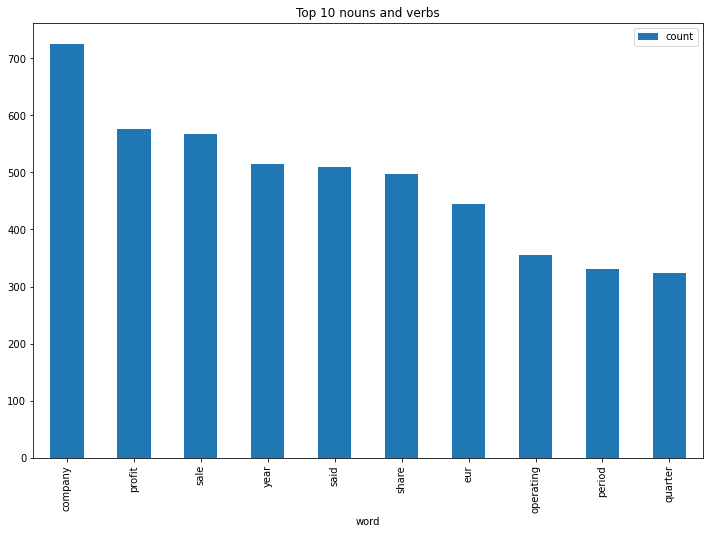

In [73]:
# Visualizing results (Barchart for top 10 nouns + verbs)
wd_df[0:10].plot.bar(x='word',figsize=(12,8),title='Top 10 nouns and verbs')

### Feature Extraction for 'Key Words'

In [74]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(dataframe['Clean_Sentence'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(dataframe['Clean_Sentence'])

In [75]:
dataframe

,Clean_Sentence
0,geosolutions technology leverage benefon gps s...
1,esi low bk real possibility
2,last quarter componenta net sale doubled eur e...
3,according finnish russian chamber commerce maj...
4,swedish buyout firm sold remaining percent sta...
...,...
5837,rising cost forced packaging producer huhtamak...
5838,nordic walking first used summer training meth...
5839,according shipping company viking line eu deci...
5840,building home improvement trade sale decreased...


### Fetch sentiments

In [76]:
# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [77]:
sentiments_using_SIA = dataframe.Clean_Sentence.apply(lambda Sentence: fetch_sentiment_using_SIA(Sentence))
pd.DataFrame(sentiments_using_SIA.value_counts())

,Clean_Sentence
pos,5081
neg,760


In [78]:
dataframe.Clean_Sentence[3]

'according finnish russian chamber commerce major construction company finland operating russia'

In [79]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(dataframe.Clean_Sentence[3])

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [80]:
df=pd.DataFrame()
df['Sentence'] = dataframe.Clean_Sentence
df['scores'] = dataframe['Clean_Sentence'].apply(lambda review: sid.polarity_scores(review))
df.head()

,Sentence,scores
0,geosolutions technology leverage benefon gps s...,"{'neg': 0.0, 'neu': 0.788, 'pos': 0.212, 'comp..."
1,esi low bk real possibility,"{'neg': 0.344, 'neu': 0.656, 'pos': 0.0, 'comp..."
2,last quarter componenta net sale doubled eur e...,"{'neg': 0.099, 'neu': 0.776, 'pos': 0.125, 'co..."
3,according finnish russian chamber commerce maj...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,swedish buyout firm sold remaining percent sta...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [81]:
df['compound']  = df['scores'].apply(lambda scores: scores['compound'])
df.head()

,Sentence,scores,compound
0,geosolutions technology leverage benefon gps s...,"{'neg': 0.0, 'neu': 0.788, 'pos': 0.212, 'comp...",0.6249
1,esi low bk real possibility,"{'neg': 0.344, 'neu': 0.656, 'pos': 0.0, 'comp...",-0.2732
2,last quarter componenta net sale doubled eur e...,"{'neg': 0.099, 'neu': 0.776, 'pos': 0.125, 'co...",0.1531
3,according finnish russian chamber commerce maj...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,swedish buyout firm sold remaining percent sta...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


In [82]:
df['sentiment'] = df['compound'].apply(lambda c: 'Positive' if c >=0.05 else ('Negative' if c<=-0.05  else 'Neutral'))
df

,Sentence,scores,compound,sentiment
0,geosolutions technology leverage benefon gps s...,"{'neg': 0.0, 'neu': 0.788, 'pos': 0.212, 'comp...",0.6249,Positive
1,esi low bk real possibility,"{'neg': 0.344, 'neu': 0.656, 'pos': 0.0, 'comp...",-0.2732,Negative
2,last quarter componenta net sale doubled eur e...,"{'neg': 0.099, 'neu': 0.776, 'pos': 0.125, 'co...",0.1531,Positive
3,according finnish russian chamber commerce maj...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
4,swedish buyout firm sold remaining percent sta...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
...,...,...,...,...
5837,rising cost forced packaging producer huhtamak...,"{'neg': 0.328, 'neu': 0.672, 'pos': 0.0, 'comp...",-0.5267,Negative
5838,nordic walking first used summer training meth...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
5839,according shipping company viking line eu deci...,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp...",0.2023,Positive
5840,building home improvement trade sale decreased...,"{'neg': 0.0, 'neu': 0.7, 'pos': 0.3, 'compound...",0.4588,Positive


In [83]:
dataframe.describe()

,Clean_Sentence
count,5841
unique,5249
top,earnings per share eps amounted loss eur
freq,7


In [84]:
temp = df.groupby('sentiment').count()['Sentence'].reset_index().sort_values(by='Sentence',ascending=False)
temp.style.background_gradient(cmap='rainbow')

,sentiment,Sentence
2,Positive,2765
1,Neutral,2343
0,Negative,733


<AxesSubplot:xlabel='sentiment', ylabel='count'>

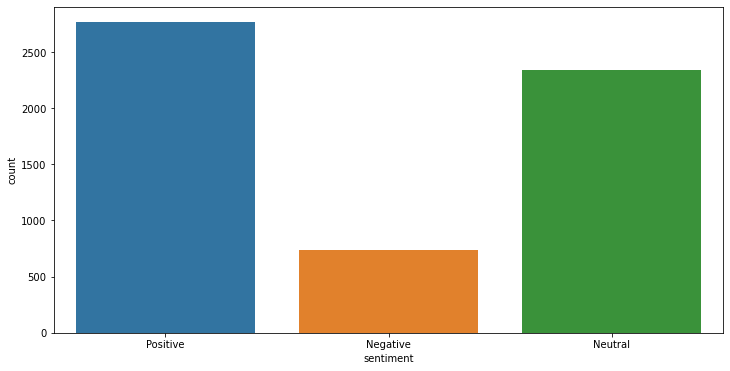

In [85]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=df)

C:\Users\Madhu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='compound', ylabel='Density'>

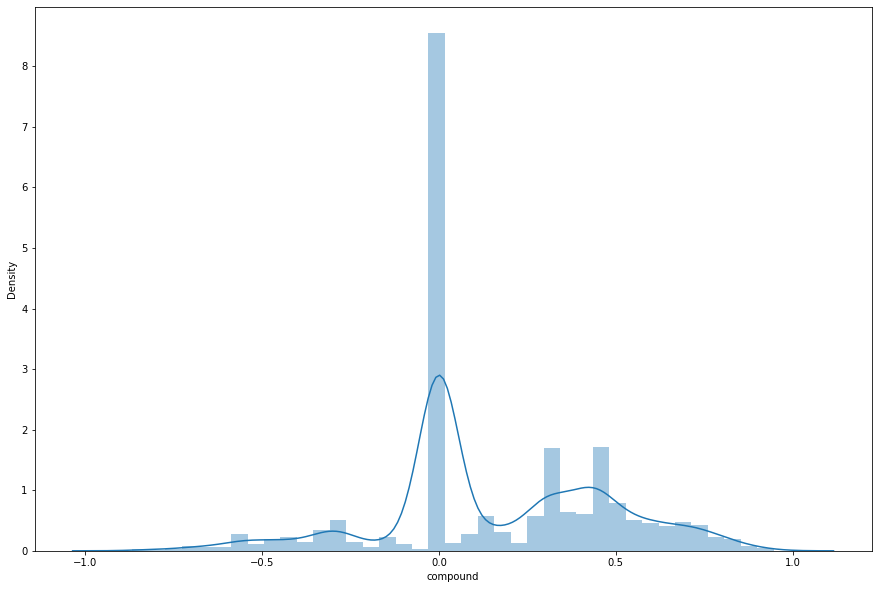

In [86]:
# Plotting the sentiment value for whole review
import seaborn as sns
plt.figure(figsize=(15,10))
sns.distplot(df['compound'])

<AxesSubplot:ylabel='compound'>

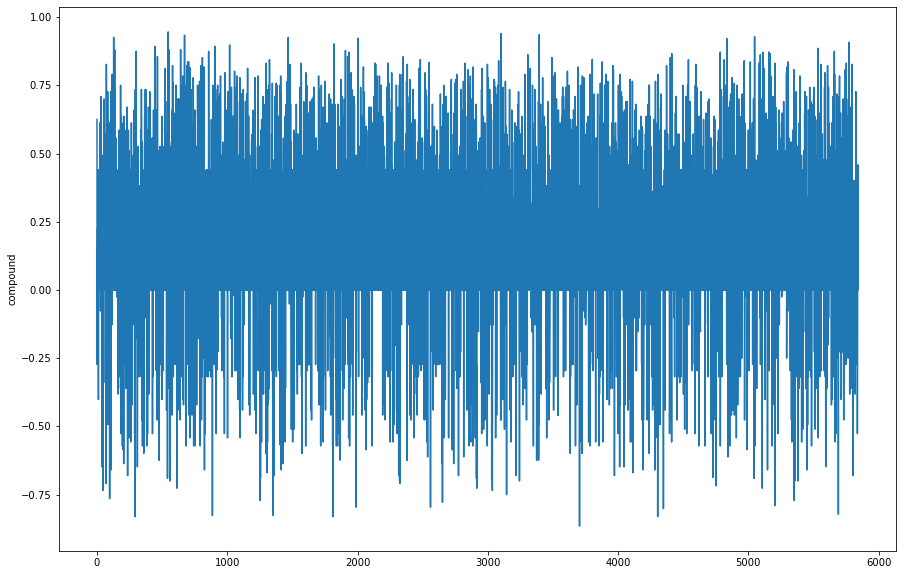

In [87]:
# Plotting the line plot for sentiment value of whole review
plt.figure(figsize=(15,10))
sns.lineplot(y='compound',x=df.index,data=df)

In [88]:
df['word_count'] = df['Sentence'].apply(lambda x: len(str(x).split(" ")))
df[['Sentence','word_count']].head()

,Sentence,word_count
0,geosolutions technology leverage benefon gps s...,21
1,esi low bk real possibility,5
2,last quarter componenta net sale doubled eur e...,20
3,according finnish russian chamber commerce maj...,11
4,swedish buyout firm sold remaining percent sta...,14


<AxesSubplot:title={'center':'Sentence sentiment value to sentence word count'}, xlabel='word_count', ylabel='compound'>

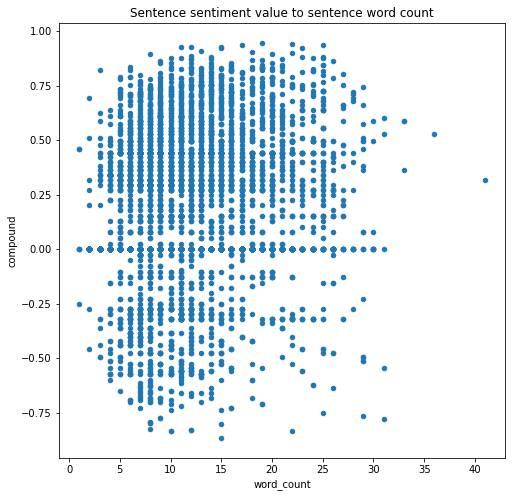

In [89]:
# Correlation analysis
df.plot.scatter(x='word_count',y='compound',figsize=(8,8),title='Sentence sentiment value to sentence word count')

In [90]:
sentiments_using_textblob = dataframe.Clean_Sentence.apply(lambda dataframe: fetch_sentiment_using_textblob(dataframe))
pd.DataFrame(sentiments_using_textblob.value_counts())

,Clean_Sentence
pos,4935
neg,906


In [91]:
dataframe['sentiment'] = sentiments_using_SIA
dataframe.head()

,Clean_Sentence,sentiment
0,geosolutions technology leverage benefon gps s...,pos
1,esi low bk real possibility,neg
2,last quarter componenta net sale doubled eur e...,pos
3,according finnish russian chamber commerce maj...,pos
4,swedish buyout firm sold remaining percent sta...,pos


## Story Generation and Visualization

In [92]:
#Most common words in positive tweets
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

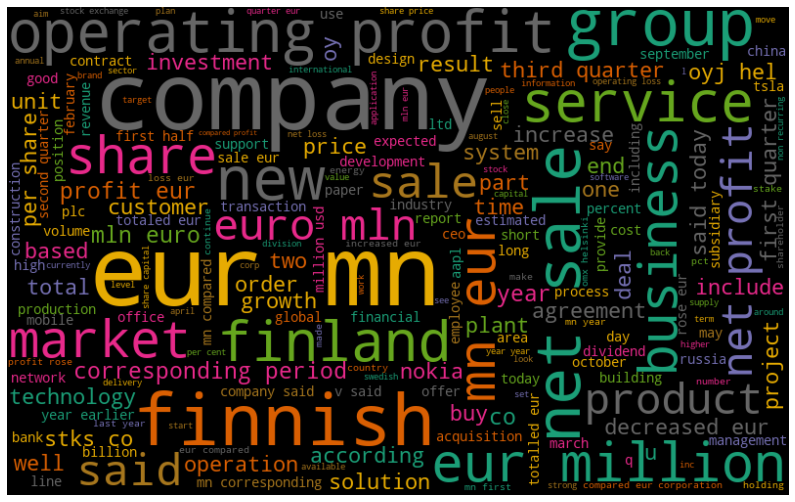

In [93]:
all_words = ' '.join([text for text in dataframe['Clean_Sentence'][dataframe.sentiment == 'pos']])
generate_wordcloud(all_words)

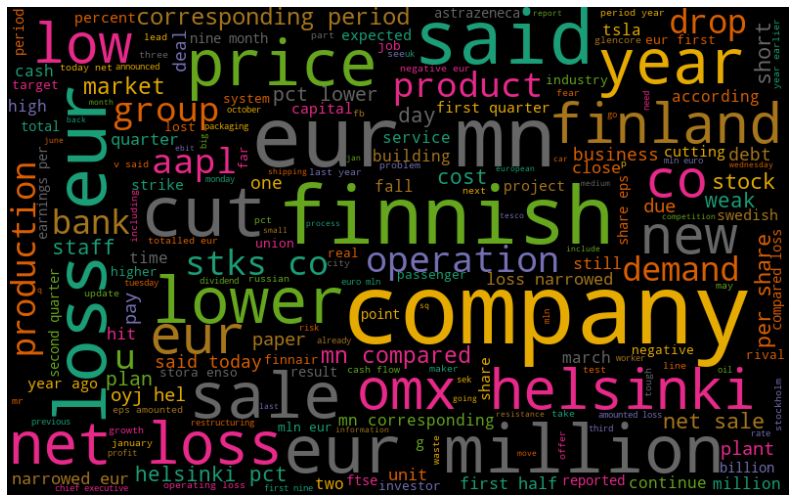

In [94]:
all_words = ' '.join([text for text in dataframe['Clean_Sentence'][dataframe.sentiment == 'neg']])
generate_wordcloud(all_words)

### Model Building: Sentiment Analysis

In [95]:
import nltk
from gensim.models.phrases import Phrases, Phraser

# Define a list of strings representing the documents in your corpus
texts = ['Clean_Sentence']

# Tokenize and preprocess the text data
def preprocess_text(text):
    # Perform preprocessing steps here
    return text

tokenized_text = [nltk.word_tokenize(preprocess_text(text)) for text in texts]

# Create bigrams
bigram_phrases = Phrases(tokenized_text, min_count=5, threshold=100)
bigram = Phraser(bigram_phrases)
bigram_tokenized_text = [bigram[text] for text in tokenized_text]

# Create trigrams
trigram_phrases = Phrases(bigram_tokenized_text, min_count=5, threshold=100)
trigram = Phraser(trigram_phrases)
trigram_tokenized_text = [trigram[text] for text in bigram_tokenized_text]

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the preprocessed text data into feature vectors using TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,3))
X = vectorizer.fit_transform([" ".join(tokens) for tokens in trigram_tokenized_text])

In [97]:
print(df.columns)
print(dataframe.columns)

Index(['Sentence', 'scores', 'compound', 'sentiment', 'word_count'], dtype='object')
Index(['Clean_Sentence', 'sentiment'], dtype='object')


In [98]:
from sklearn.naive_bayes import MultinomialNB

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataframe['Clean_Sentence'], df['sentiment'], test_size=0.3, random_state=42)

# Vectorize the training data
vectorizer = CountVectorizer(stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)

# Train the model
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)

# Vectorize the testing data and predict the sentiment
X_test_vectorized = vectorizer.transform(X_test)
y_pred = model.predict(X_test_vectorized)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 70.79%


In [99]:
# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vectorized, y_train)

# Vectorize the testing data and predict the sentiment
X_test_vectorized = vectorizer.transform(X_test)
y_pred = model.predict(X_test_vectorized)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 81.97%


In [100]:
# Train the model
model = SVC(kernel='linear')
model.fit(X_train_vectorized, y_train)

# Vectorize the testing data and predict the sentiment
X_test_vectorized = vectorizer.transform(X_test)
y_pred = model.predict(X_test_vectorized)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 83.00%


In [101]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Create a pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_estimators=100))
    ])



In [102]:
# Fit the pipeline on the data
rf_pipeline.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = rf_pipeline.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:', classification_report(y_test, y_pred))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred))

Accuracy: 0.8488305761551626
Classification Report:               precision    recall  f1-score   support

    Negative       0.97      0.53      0.68       221
     Neutral       0.76      0.97      0.85       717
    Positive       0.94      0.83      0.88       815

    accuracy                           0.85      1753
   macro avg       0.89      0.78      0.81      1753
weighted avg       0.87      0.85      0.84      1753

Confusion Matrix: [[117  84  20]
 [  1 695  21]
 [  3 136 676]]


In [103]:
# Create a pipeline
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline on the data
nb_pipeline.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = nb_pipeline.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:', classification_report(y_test, y_pred))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred))

Accuracy: 0.6588705077010839
Classification Report:               precision    recall  f1-score   support

    Negative       0.92      0.05      0.09       221
     Neutral       0.73      0.57      0.64       717
    Positive       0.62      0.90      0.73       815

    accuracy                           0.66      1753
   macro avg       0.76      0.51      0.49      1753
weighted avg       0.70      0.66      0.62      1753

Confusion Matrix: [[ 11  69 141]
 [  0 412 305]
 [  1  82 732]]


In [104]:
# Create a pipeline
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Fit the pipeline on the data
lr_pipeline.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = lr_pipeline.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:', classification_report(y_test, y_pred))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred))

Accuracy: 0.780376497432972
Classification Report:               precision    recall  f1-score   support

    Negative       0.95      0.32      0.48       221
     Neutral       0.72      0.87      0.79       717
    Positive       0.82      0.83      0.83       815

    accuracy                           0.78      1753
   macro avg       0.83      0.67      0.70      1753
weighted avg       0.80      0.78      0.77      1753

Confusion Matrix: [[ 71  98  52]
 [  2 624  91]
 [  2 140 673]]


In [105]:
# Create a pipeline
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline on the data
nb_pipeline.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = nb_pipeline.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:', classification_report(y_test, y_pred))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred))

Accuracy: 0.6588705077010839
Classification Report:               precision    recall  f1-score   support

    Negative       0.92      0.05      0.09       221
     Neutral       0.73      0.57      0.64       717
    Positive       0.62      0.90      0.73       815

    accuracy                           0.66      1753
   macro avg       0.76      0.51      0.49      1753
weighted avg       0.70      0.66      0.62      1753

Confusion Matrix: [[ 11  69 141]
 [  0 412 305]
 [  1  82 732]]


In [106]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid to search over
param_grid = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'clf__n_estimators': [50, 100, 150],
    'clf__max_depth': [5, 10, None]
}

# Create a pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

# Use GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(rf_pipeline, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'clf__max_depth': None, 'clf__n_estimators': 150, 'tfidf__max_df': 0.5}
Best score:  0.8314556505552846


In [107]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [108]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train_vectorized, y_train)

print_score(rf_clf, X_train_vectorized, y_train, X_test_vectorized, y_test, train=True)
print_score(rf_clf, X_train_vectorized, y_train, X_test_vectorized, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
           Negative  Neutral  Positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support       512.0   1626.0    1950.0       1.0     4088.0        4088.0
_______________________________________________
Confusion Matrix: 
 [[ 512    0    0]
 [   0 1626    0]
 [   0    0 1950]]

Test Result:
Accuracy Score: 83.80%
_______________________________________________
CLASSIFICATION REPORT:
             Negative     Neutral    Positive  accuracy    macro avg  \
precision    0.929134    0.744909    0.946609  0.837992     0.873551   
recall       0.533937    0.969317    0.804908  0.837992     0.769387   
f1-score     0.678161    0.842424    0.870027  0.837992     0.796871   
su

In [109]:
from imblearn.over_sampling import SMOTE

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(X_train_vectorized, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({'Positive': 1950, 'Neutral': 1626, 'Negative': 512})
After Counter({'Neutral': 1950, 'Positive': 1950, 'Negative': 1950})


In [110]:
from imblearn.combine import SMOTETomek
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek

smtom = SMOTETomek(random_state=139)

x_train_smtom, y_train_smtom = smtom.fit_resample(X_train_vectorized, y_train)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({'Positive': 1950, 'Neutral': 1626, 'Negative': 512})
After Counter({'Negative': 1946, 'Positive': 1941, 'Neutral': 1939})


In [111]:
from imblearn.combine import SMOTEENN
counter = Counter(y_train)
print('Before',counter)
#oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
x_train_smenn, y_train_smenn = smenn.fit_resample(X_train_vectorized, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({'Positive': 1950, 'Neutral': 1626, 'Negative': 512})
After Counter({'Negative': 1759, 'Positive': 343, 'Neutral': 321})


In [112]:
sampled_data = {
    'ACTUAL':[X_train_vectorized, y_train],
    'SMOTE':[x_train_sm, y_train_sm],
    'SMOTE_TOMEK':[x_train_smtom, y_train_smtom],
    'SMOTE_ENN':[x_train_smenn, y_train_smenn]
}

In [113]:
def test_eval(clf_model, X_test_vectorized, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test_vectorized)
    y_pred=clf_model.predict(X_test_vectorized)

    print('Confusion Matrix')
    print('='*60)
    #plot_confusion_matrix(clf_model, X_test_vectorized, y_test)  
    #plt.show() 
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    #print('AUC-ROC')
    #print('='*60)
    #print(roc_auc_score(y_test, y_prob[:,1], multi_class='ovo'))
    
    #x = roc_auc_score(y_test, y_prob[:,1])
    f1 = f1_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')
          
    
    return algo,precision,recall,f1,sampling

In [114]:
model_params = {

    'random-forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
             "n_estimators": [5, 10, 15, 20, 25], 
             'max_depth': [i for i in range(5,16,2)],
             'min_samples_split': [2, 5, 10, 15, 20, 50, 100],
             'min_samples_leaf': [1, 2, 5],
             'criterion': ['gini', 'entropy'],
             'max_features': ['log2', 'sqrt', 'auto']

         }
    }
}

In [115]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
cv = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)
output = []
for model , model_hp in model_params.items():
    for resam , data in sampled_data.items():
        clf = RandomizedSearchCV(model_hp['model'], model_hp['params'],cv = cv, scoring='roc_auc', n_jobs=-1 )
        clf.fit(data[0], data[1])
        clf_best = clf.best_estimator_
        print('x'*60)
        print(model+' with ' + resam)
        print('='*60)
        output.append(test_eval(clf_best, X_test_vectorized, y_test, model, resam))

C:\Users\Madhu\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
random-forest with ACTUAL
Confusion Matrix
[[  2  27 192]
 [  0 134 583]
 [  0  44 771]] 

Classification Report
              precision    recall  f1-score   support

    Negative       1.00      0.01      0.02       221
     Neutral       0.65      0.19      0.29       717
    Positive       0.50      0.95      0.65       815

    accuracy                           0.52      1753
   macro avg       0.72      0.38      0.32      1753
weighted avg       0.63      0.52      0.42      1753
 



C:\Users\Madhu\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
random-forest with SMOTE
Confusion Matrix
[[145  36  40]
 [253 334 130]
 [171 163 481]] 

Classification Report
              precision    recall  f1-score   support

    Negative       0.25      0.66      0.37       221
     Neutral       0.63      0.47      0.53       717
    Positive       0.74      0.59      0.66       815

    accuracy                           0.55      1753
   macro avg       0.54      0.57      0.52      1753
weighted avg       0.63      0.55      0.57      1753
 



C:\Users\Madhu\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
random-forest with SMOTE_TOMEK
Confusion Matrix
[[125  47  49]
 [281 316 120]
 [205 159 451]] 

Classification Report
              precision    recall  f1-score   support

    Negative       0.20      0.57      0.30       221
     Neutral       0.61      0.44      0.51       717
    Positive       0.73      0.55      0.63       815

    accuracy                           0.51      1753
   macro avg       0.51      0.52      0.48      1753
weighted avg       0.61      0.51      0.54      1753
 

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
random-forest with SMOTE_ENN
Confusion Matrix
[[221   0   0]
 [717   0   0]
 [815   0   0]] 

Classification Report
              precision    recall  f1-score   support

    Negative       0.13      1.00      0.22       221
     Neutral       0.00      0.00      0.00       717
    Positive       0.00      0.00      0.00       815

    accuracy                           0.13

C:\Users\Madhu\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\Madhu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Madhu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Madhu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 i

In [116]:
#base model
score_array = []
for each in range(1,200):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 1) 
    rf_loop.fit(X_train_vectorized,y_train)
    score_array.append(rf_loop.score(X_test_vectorized,y_test))

In [117]:
loc = np.array(score_array).max()
score_array.index(loc)+1

32

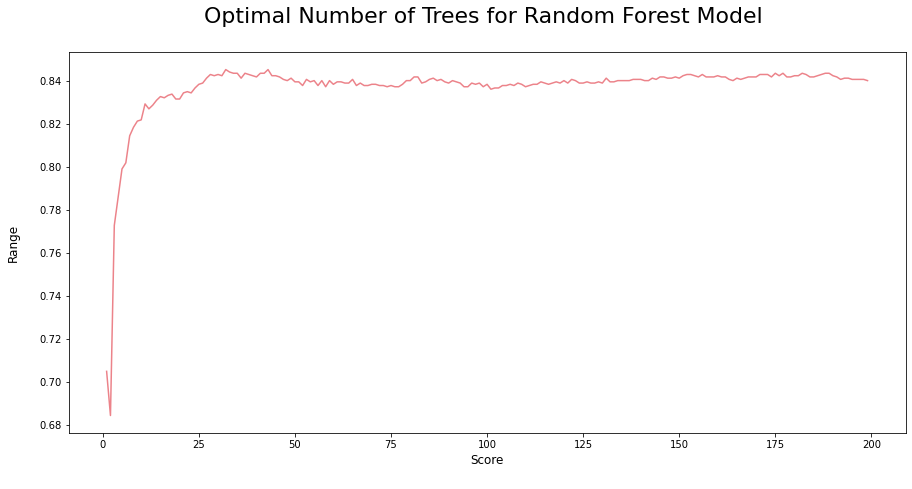

In [118]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,200),score_array, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

In [119]:
n_estimators = [int(x) for x in np.linspace(start=0, stop=200, num=200)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='f1',param_distributions=random_grid, n_iter=100, cv=3, 
                               verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(X_train_vectorized, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(X_train_vectorized, y_train)

print_score(rf_clf, X_train_vectorized, y_train, X_test_vectorized, y_test, train=True)
print_score(rf_clf, X_train_vectorized, y_train, X_test_vectorized, y_test, train=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\Madhu\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best paramters: {'n_estimators': 195, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True})
Train Result:
Accuracy Score: 78.60%
_______________________________________________
CLASSIFICATION REPORT:
             Negative      Neutral     Positive  accuracy    macro avg  \
precision    0.952703     0.716634     0.849359  0.785959     0.839565   
recall       0.275391     0.911439     0.815385  0.785959     0.667405   
f1-score     0.427273     0.802382     0.832025  0.785959     0.687227   
support    512.000000  1626.000000  1950.000000  0.785959  4088.000000   

           weighted avg  
precision      0.809511  
recall         0.785959  
f1-score       0.769542  
support     4088.000000  
_______________________________________________
Confusion Matrix: 
 [[ 141  232  139]
 [   1 1482  143]
 [   6  354 1590]]

Test Result:
Accuracy Score: 73.25%
_______________________________________________
CLASSIFICATION REPORT:
             N

In [120]:
# Save the trained model
import pickle
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_clf, file)

In [121]:
# Load the model from the file
with open('rf_model.pkl', 'rb') as file:
    saved_model = pickle.load(file)

In [126]:
import streamlit as st
import pandas as pd
import numpy as np
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Download the required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load the English stop words and the lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define a list of strings representing the documents in your corpus
texts = ['Clean_Sentence']

# Tokenize and preprocess the text data
def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    words = nltk.word_tokenize(text)
    # Remove stop words and lemmatize the words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Join the words back into a string
    text = ' '.join(words)
    return text

tokenized_text = [nltk.word_tokenize(preprocess_text(text)) for text in texts]

# Create bigrams
bigram_phrases = Phrases(tokenized_text, min_count=5, threshold=100)
bigram = Phraser(bigram_phrases)
bigram_tokenized_text = [bigram[text] for text in tokenized_text]

# Create trigrams
trigram_phrases = Phrases(bigram_tokenized_text, min_count=5, threshold=100)
trigram = Phraser(trigram_phrases)
trigram_tokenized_text = [trigram[text] for text in bigram_tokenized_text]

# Define the vectorization function
vectorizer = TfidfVectorizer(ngram_range=(1, 3))

# Load the pre-trained model
model = RandomForestClassifier()

# Define the predict function
def predict_sentiment(text):
    # Preprocess the text
    preprocessed_text = preprocess_text(text)
    # Create trigrams
    trigram_text = trigram[[bigram[[preprocessed_text.split()]]]]
    # Join the words in the trigram_text into a string
    trigram_text = [' '.join(words) for words in trigram_text]
    # Vectorize the trigram_text
    vectorized_text = vectorizer.transform(trigram_text)
    # Predict the sentiment
    sentiment = model.predict(vectorized_text)[0]
    return sentiment

# Define the streamlit app
def app():
    st.set_page_config(page_title='Financial Sentiment Analysis', page_icon=':moneybag:', layout='wide')
    st.title('Financial Sentiment Analysis')
    st.markdown('Enter some text and the app will predict its sentiment.')
    # Create a text input box for the user to enter text
    text_input = st.text_input('Enter some text:')
    if text_input:
        # Predict the sentiment and display the result
        sentiment = predict_sentiment(text_input)
        if sentiment == 0:
            st.error('The sentiment of the text is Negative :chart_with_downwards_trend:')
        elif sentiment == 1:
            st.warning('The sentiment of the text is Neutral :bar_chart:')
        elif sentiment == 2:
            st.success('The sentiment of the text is Positive :chart_with_upwards_trend:')

if __name__ == "__main__":
    app()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2023-05-08 12:47:21.672 collecting all words and their counts
2023-05-08 12:47:21.680 PROGRESS: at sentence #0, processed 0 words and 0 word types
2023-05-08 12:47:21.680 collected 3 token types (unigram + bigrams) from a corpus of 2 words and 1 sentences
2023-05-08 12:47:21.680 merged Phrases<3 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
2023-05-08 12:47:21.680 Phrases lifecycle event {'msg': 'built Phrases<3 vocab, min_count=5, threshold=100, max_vocab_size=40000000> in 0.01s', 'datetime': '2023-05-08T12:47:2